# Deep LSTM based Malware Analysis

## Deep learning based Sequential model for malware analysis using Windows exe API Calls

Malware development has seen diversity in terms of architecture and features. This advancement in the competencies of malware poses a severe threat and opens new research dimensions in malware detection. This study is focused on metamorphic malware that is the most advanced member of the malware family. It is quite impossible for anti-virus applications using traditional signature-based methods to detect metamorphic malware, which makes it difficult to classify this type of malware accordingly. Recent research literature about malware detection and classification discusses this issue related to malware behavior.

**Cite The DataSet**  
If you find this implementation useful please cite it:

    @article{catak_lstm2020,
      author  = {Ferhat Ozgur Catak}, 
      title   = {Deep learning based Sequential model for malware analysis using Windows exe API Calls},
      journal = {Peerj Computer Science},
      year    = 2020,
      pages   = {1-17},
      month   = 7
    }
  
You can access the dataset from my  [My GitHub Repository](https://github.com/ocatak/lstm_malware_detection).

## Introduction

Malicious software, commonly known as malware, is any software intentionally designed to cause damage to computer systems and compromise user security. An application or code is considered malware if it secretly acts against the interests of the computer user and performs malicious activities. Malware targets various platforms such as servers, personal computers, mobile phones, and cameras to gain unauthorized access, steal personal data, and disrupt the normal function of the system. 

One approach to deal with malware protection problem is by identifying the malicious software and evaluating its behavior. Usually, this problem is solved through the analysis of malware behavior. This field closely follows the model of malicious software family, which also reflects the pattern of malicious behavior. There are very few studies that have demonstrated the methods of classification according to the malware families.

All operating system API calls made to act by any software show the overall direction of this program. Whether this program is malware or not can be learned by examining these actions in-depth. If it is malware, then what is its malware family. The malware-made operating system API call is a data attribute, and the sequence in which those API calls are generated is also critical to detect the malware family. Performing specific API calls is a particular order that represents a behavior. One of the deep learning methods LSTM (long-short term memory) has been commonly used in the processing of such time-sequential data.

## System Architecture

This research has two main objectives; first, we created a relevant dataset, and then, using this dataset, we did a comparative study using various machine learning to detect and classify malware automatically based on their types.

### Dataset Creation

One of the most important contributions of this work is the new Windows PE Malware API sequence dataset, which contains malware analysis information. There are 7107 malware from different classes in this dataset. The Cuckoo Sandbox application, as explained above, is used to obtain the Windows API call sequences of malicious software, and VirusTotal Service is used to detect the classes of malware.

The following figure illustrates the system architecture used to collect the data and to classify them using LSTM algorithms.
![Malware dataset](fig-1.png)

Our system consists of three main parts, data collection, data pre-processing and analyses, and data classification.

The following steps were followed when creating the dataset.

Cuckoo Sandbox application is installed on a computer running Ubuntu Linux distribution. The analysis machine was run as a virtual server to run and analyze malware. The Windows operating system is installed on this server.

## Let’s coding
We import the usual standard libraries to build an LSTM model to detect the malware.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import SpatialDropout1D
from mlxtend.plotting import plot_confusion_matrix

In this work, we will use standard our malware dataset to show the results. You can access the dataset from [My GitHub Repository](https://github.com/ocatak/lstm_malware_detection). We need to merge the call and the label datasets.

In [2]:
malware_calls_df = pd.read_csv("calls.zip", compression="zip",
                               sep="\t", names=["API_Calls"])

malware_labels_df = pd.read_csv("types.zip", compression="zip",
                                sep="\t", names=["API_Labels"])

malware_calls_df["API_Labels"] = malware_labels_df.API_Labels
malware_calls_df["API_Calls"] = malware_calls_df.API_Calls.apply(lambda x: " ".join(x.split(",")))

malware_calls_df["API_Labels"] = malware_calls_df.API_Labels.apply(lambda x: 1 if x == "Virus" else 0)

Let's analyze the class distribution

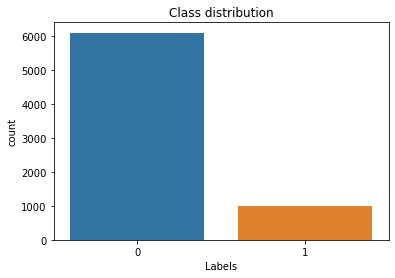

In [15]:
sns.countplot(malware_calls_df.API_Labels)
plt.xlabel('Labels')
plt.title('Class distribution')
plt.savefig("class_distribution.png")
plt.show()

![Class distribution](class_distribution.png)

Now we can create our sequence matrix. In order to build an LSTM model, you need to create a tokenization based sequence matrix as the input dataset

In [4]:
max_words = 800
max_len = 100

X = malware_calls_df.API_Calls
Y = malware_calls_df.API_Labels.astype('category').cat.codes

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
print('Found %s unique tokens.' % len(tok.word_index))
X = tok.texts_to_sequences(X.values)
X = sequence.pad_sequences(X, maxlen=max_len)
print('Shape of data tensor:', X.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.15)

le = LabelEncoder()
Y_train_enc = le.fit_transform(Y_train)
Y_train_enc = np_utils.to_categorical(Y_train_enc)

Y_test_enc = le.transform(Y_test)
Y_test_enc = np_utils.to_categorical(Y_test_enc)

Found 278 unique tokens.
Shape of data tensor: (7107, 100)


The LSTM based classification model is then given for example as exercise here:

In [5]:
def malware_model(act_func="softsign"):
    model = Sequential()
    model.add(Embedding(max_words, 300, input_length=max_len))
    model.add(SpatialDropout1D(0.1))
    model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,
                   return_sequences=True, activation=act_func))
    model.add(LSTM(32, dropout=0.1, activation=act_func, return_sequences=True))
    model.add(LSTM(32, dropout=0.1, activation=act_func))
    model.add(Dense(128, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation=act_func))
    model.add(Dropout(0.1))
    model.add(Dense(1, name='out_layer', activation="linear"))
    return model

The next step is to train the model. I trained and saved my model. Because of the dataset, the training stage take lots of time. In order to reduce the execution time you can load my previous trained model from the GitHub repository.

In [6]:
model = malware_model()
print(model.summary())
model.compile(loss='mse', optimizer="rmsprop",
              metrics=['accuracy'])

filepath = "lstm-malware-model.hdf5"
model.load_weights(filepath)

history = model.fit(X_train, Y_train, batch_size=1000, epochs=10,
                    validation_data=(X_test, Y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          240000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 32)           42624     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 32)           8320      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

## Model Evaluation

Now, we have finished the training phase of the LSTM model. We can evaluate our model's classification performance using the confusion matrix. According to the confusion matrix, the model’s classification performance quite good.

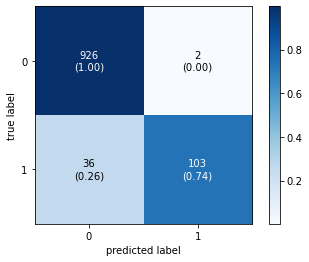

In [12]:
y_test_pred = model.predict_classes(X_test)
cm = confusion_matrix(Y_test, y_test_pred)

plot_confusion_matrix(conf_mat=cm,
                      show_absolute=True,
                      show_normed=True,
                      colorbar=True)
plt.savefig("confusion_matrix.png")
plt.show()

![Confusion matrix](confusion_matrix.png)

Let's continue with the training history of our model.

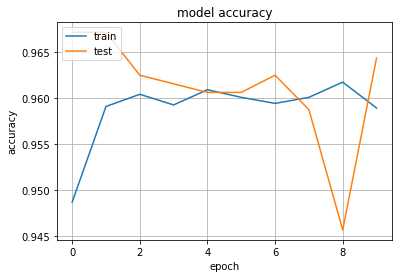

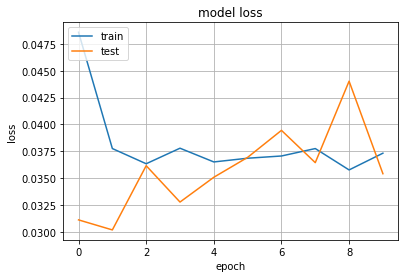

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.savefig("accuracy.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.savefig("loss.png")
plt.show()

![Accuracy history](accuracy.png)
![Loss history](loss.png)

## Conclusion

The purpose of this study was to create an LSTM based malware detection model using my previous malware dataset. Although our dataset contains instances that belong to some malware families with unbalanced distribution, we have shown that this problem does not affect classification performance.